In [1]:
import os
import sys
from pathlib import Path

# Add source directory to system path
source_dir = str(Path(os.getcwd()).parent / 'src')
sys.path.append(source_dir)

Data(x=[75, 1], edge_index=[2, 1478], y=[1], pos=[75, 2])
Label: 1


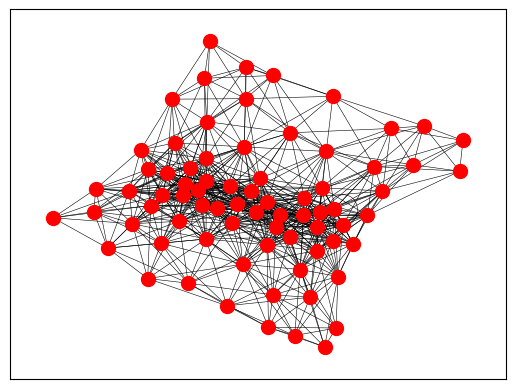

In [7]:
from torch_geometric.datasets import MNISTSuperpixels
from torch_geometric.utils import to_networkx
from pathlib import Path
import networkx as nx
import matplotlib.pyplot as plt
import os
import numpy as np

root = str(Path(os.getcwd()).parent / 'data' / 'mnist-superpixels')
dataset = MNISTSuperpixels(root=root)
sample = dataset[int(np.random.sample()*len(dataset))]
print(sample)
print("Label: {}".format(sample.y[0].cpu().numpy()))
G = to_networkx(sample, to_undirected=True)
nx.draw_networkx(G, with_labels=False, node_size=100, node_color="red", width=0.4)

In [3]:
from models import GNN, GNNConvLayer
model = GNN(dataset.num_features, 128, dataset.num_classes, numLayers=4, dropout=0.2, convLayer=GNNConvLayer.GAT, skip=True)
print("Number of Model Parameters: {}".format(sum(p.numel() for p in model.parameters())))
print(model)

Number of Model Parameters: 118410
GNN(
  (convs): ModuleList(
    (0): GraphSage(1, 128)
    (1): GraphSage(128, 128)
    (2): GraphSage(128, 128)
    (3): GraphSage(128, 128)
  )
  (bns): ModuleList(
    (0): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (postMP): Sequential(
    (0): Linear(in_features=128, out_features=128, bias=True)
    (1): Dropout(p=0.2, inplace=False)
    (2): Linear(in_features=128, out_features=10, bias=True)
  )
  (logSoftmax): LogSoftmax(dim=1)
)


In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch_geometric.loader import DataLoader
from tqdm import tqdm
from utils import saveCheckpoint


# Training Parameters
num_epochs = 500
device = "cuda" if torch.cuda.is_available() else "cpu"
model = model.to(device)

# dataset = dataset[: int(len(dataset) * 0.5)]   # comment out if using full dataset
train_split, valid_split, test_split = 0.8, 0.1, 0.1
train_size = int(len(dataset) * train_split)
valid_size = int(len(dataset) * valid_split)
test_size = int(len(dataset) * test_split)

# Hyperparameters
learning_rate = 0.01

# Data Loader
batch_size = 64
train_loader = DataLoader(dataset[: train_size], batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(dataset[train_size: train_size + valid_size], batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset[train_size + valid_size:], batch_size=batch_size, shuffle=True)

# Loss Function and Optimizer
loss_func = nn.NLLLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)